In [1]:
!nvidia-smi

Sun Dec 20 13:10:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# libraries
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.applications.xception import preprocess_input,decode_predictions
from keras.models import load_model
from keras.layers import Input
from keras.models import Model,Sequential
from keras.utils import np_utils
from sklearn.utils import shuffle
import pandas as pd
import random
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, Adamax, SGD
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
# data path
train_dir = "../input/lisc-data/lisc_data/train"
validation_dir = "../input/lisc-data/lisc_data/validation"

In [89]:
# Xception
image_input = Input(shape=(299, 299, 3))
model = Xception(weights='imagenet', include_top=False, input_tensor=image_input, classes=5)

# set Trainable
for layer in model.layers[:46]:
   layer.trainable = True

# grab last layer
last_layer = model.get_layer('block14_sepconv2_act')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)

# number of classes
x = layers.Dense(5, activation='softmax')(x)
model = Model(model.input, x)

In [63]:
# check layers
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_12
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_8
13 block2_pool
14 batch_normalization_8
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_9
23 block3_pool
24 batch_normalization_9
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_10
33 block4_pool
34 batch_normalization_10
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6

In [65]:
# check
model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

In [90]:
# compile model
model.compile(optimizer = Adam(lr=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

In [32]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [67]:
# augment train data
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=270,
    brightness_range=(0.2,0.8),
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale=1./255.
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(299, 299)
)  

# Flow validation images in batches of 32 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(299, 299)
)

Found 205 images belonging to 5 classes.
Found 20 images belonging to 5 classes.


In [91]:
# fit model
history = model.fit_generator(
    train_generator,
    epochs=80,
    validation_data=validation_generator,
    callbacks=[reduce_lr]
)

Epoch 1/80
7/7 [==============================] - 7s 1s/step - loss: 1.6851 - accuracy: 0.1463 - val_loss: 1.6113 - val_accuracy: 0.2000
Epoch 2/80
7/7 [==============================] - 7s 1s/step - loss: 1.6108 - accuracy: 0.2195 - val_loss: 1.6091 - val_accuracy: 0.1500
Epoch 3/80
7/7 [==============================] - 6s 916ms/step - loss: 1.5624 - accuracy: 0.2927 - val_loss: 1.6035 - val_accuracy: 0.1500
Epoch 4/80
7/7 [==============================] - 7s 1s/step - loss: 1.5428 - accuracy: 0.3366 - val_loss: 1.5961 - val_accuracy: 0.1500
Epoch 5/80
7/7 [==============================] - 7s 995ms/step - loss: 1.4959 - accuracy: 0.4098 - val_loss: 1.5850 - val_accuracy: 0.1500
Epoch 6/80
7/7 [==============================] - 8s 1s/step - loss: 1.4333 - accuracy: 0.4488 - val_loss: 1.5711 - val_accuracy: 0.2000
Epoch 7/80
7/7 [==============================] - 7s 948ms/step - loss: 1.3985 - accuracy: 0.5561 - val_loss: 1.5530 - val_accuracy: 0.2500
Epoch 8/80
7/7 [================

7/7 [==============================] - 7s 1s/step - loss: 0.2114 - accuracy: 0.9463 - val_loss: 0.7603 - val_accuracy: 0.7500
Epoch 58/80
7/7 [==============================] - 7s 990ms/step - loss: 0.2393 - accuracy: 0.9463 - val_loss: 0.7599 - val_accuracy: 0.7500
Epoch 59/80
7/7 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9561
Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
7/7 [==============================] - 8s 1s/step - loss: 0.1945 - accuracy: 0.9561 - val_loss: 0.7572 - val_accuracy: 0.7500
Epoch 60/80
7/7 [==============================] - 7s 944ms/step - loss: 0.2028 - accuracy: 0.9512 - val_loss: 0.7573 - val_accuracy: 0.7500
Epoch 61/80
7/7 [==============================] - 8s 1s/step - loss: 0.1939 - accuracy: 0.9610 - val_loss: 0.7608 - val_accuracy: 0.8000
Epoch 62/80
7/7 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9512
Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.99

In [92]:
# save model
model.save_weights('xcpn_t46_eps80_ta93.66_va0.80.h5')

In [93]:
# plot confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
test_generator = ImageDataGenerator(rescale = 1./255.)
test_data_generator = test_generator.flow_from_directory(
    validation_dir, # Put your path here
    target_size=(299, 299),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

# predict
predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

print("Classification Report")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

print("Confusion Matrix")
matrix = confusion_matrix(true_classes, predicted_classes)
print("Y axis: True labels")
print(matrix)

Found 20 images belonging to 5 classes.
Classification Report
              precision    recall  f1-score   support

    basophil       1.00      0.75      0.86         4
  eosinophil       0.67      1.00      0.80         4
  lymphocyte       0.80      1.00      0.89         4
    monocyte       1.00      0.25      0.40         4
  neutrophil       0.80      1.00      0.89         4

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.77        20
weighted avg       0.85      0.80      0.77        20

Confusion Matrix
Y axis: True labels
[[3 1 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 1 1 1 1]
 [0 0 0 0 4]]


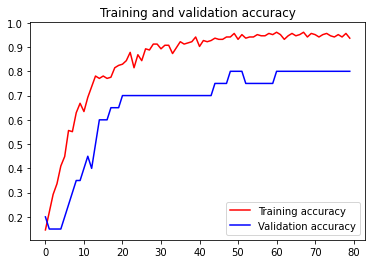

<Figure size 432x288 with 0 Axes>

In [94]:
# plot Training and validation accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

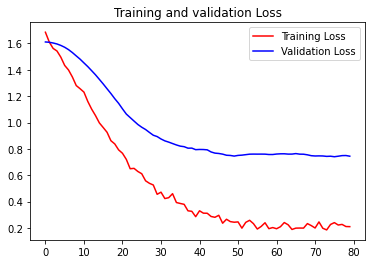

<Figure size 432x288 with 0 Axes>

In [95]:
# plot Training and validation Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Grad-CAM class activation visualization

In [97]:
# libraries
import tensorflow as tf
from tensorflow import keras
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [98]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [99]:
# check
model.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

In [100]:
# xception
# use model.summary to get the values for last_conv_layer_name and classifier_layer_names
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "global_average_pooling2d_7",
    "dense_8",
]

img_size = (299, 299)

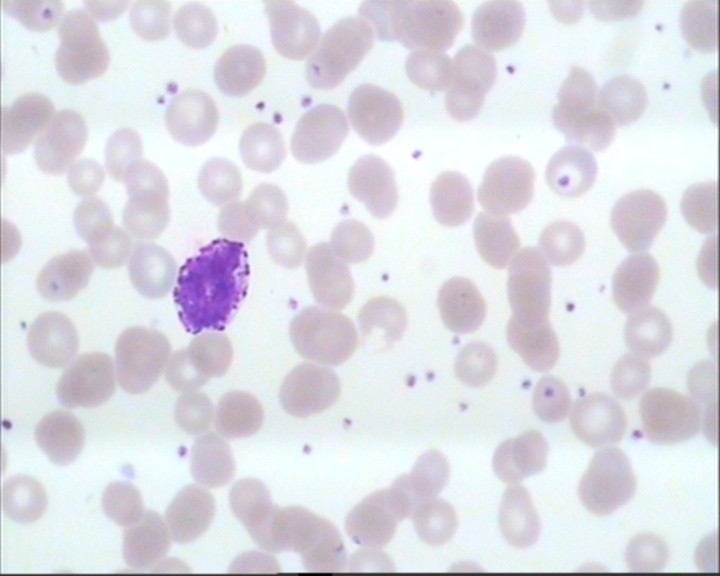

In [101]:
# test image
img_path = '../input/test-data-lisc/basophil_46.jpg'

img_array = preprocess_input(get_img_array(img_path, size=img_size))

display(Image(img_path))

Predicted: 1


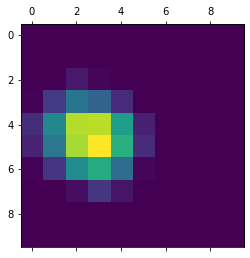

In [104]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))


# Print predictions
preds = model.predict(img_array)
print("Predicted:", np.argmax(preds))


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

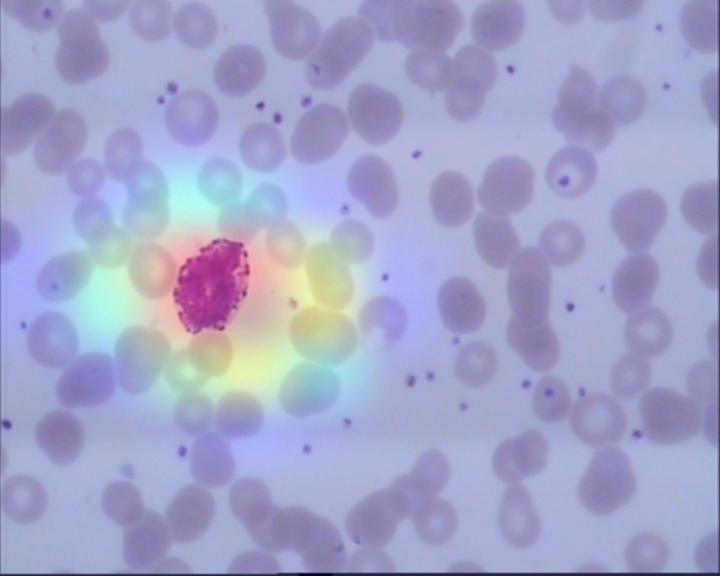

In [103]:
# load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "basophil_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))